# Bigrams 

In [2]:
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx
from nltk.corpus import brown

import nltk
import numpy as np
nltk.download('brown')

[nltk_data] Downloading package brown to /home/nancy/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
def get_sentences_from_word2vec():
    sentences=brown.sents()
    indexed_sentences=[]
    word2idx={'START':0,'END':1}
    i=2
    for sent in sentences:
        indexed_sent=[]
        for word in sent:
            word=word.lower()
            if word not in word2idx:
                word2idx[word]=i
                i+=1
            indexed_sent.append(word2idx[word])
        indexed_sentences.append(indexed_sent)
    return indexed_sentences,word2idx


def get_bigram_prob(sentences,V, start_idx,end_idx,smoothing=1):
    # (last word, current word) -> prob
    # use Add-on Smoothing
    bigram_prob=np.ones((V,V))*smoothing
    for sentence in sentences:
        for i in range(len(sentence)):
            # beginning word
            if i==0:
                bigram_prob[start_idx,sentence[i]]+=1
            # middle word
            else:
                bigram_prob[sentence[i-1],sentence[i]]+=1
            # end word
            if i==len(sentence)-1:
                bigram_prob[sentence[i],end_idx]+=1
    # normalize the counts along the rows to get probabilities
    bigram_prob/=bigram_prob.sum(axis=1,keepdims=True)
    return bigram_prob

def get_score(sentence):
    score=0
    for i in range(len(sentence)):
        # beginning word
        if i==0:
            score+=np.log(bigram_prob[start_idx,sentence[i]])
        # middle word
        else:
            score+=np.log(bigram_prob[sentence[i-1],sentence[i]])
    # final word
    score+=np.log(bigram_prob[sentence[-1],end_idx])
    # normalize the score
    return score/(len(sentence)+1)


In [5]:
# load data
sentences,word2idx = get_sentences_from_word2vec()

# vocab size
V=len(word2idx)
print(V)

# START -> first word
start_idx=word2idx['START']
# END -> last word
end_idx=word2idx['END']

49817


In [36]:
# A matrix where
# row = last word
# col = current word
# value [rol,col] = p(current word | last word)
bigram_prob = get_bigram_prob(sentences,V, start_idx,end_idx,smoothing=1)

In [38]:
idx2word={v:k for k,v in word2idx.items()}

In [54]:
def get_words(sentence):
    return ' '.join([idx2word[i] for i in sentence])

In [83]:
# when we sample a fake sentence, we want to ensure not to sample
sample_probs=np.ones(V)
sample_probs[start_idx]=0
sample_probs[end_idx]=0
sample_probs/=sample_probs.sum()

# a real sentence
# real_idx=np.random.choice(len(sentences))
# real = sentences[real_idx]
custom = "your model does not make any sense at all"
tokens = custom.lower().split()
custom = [word2idx[word] for word in tokens]

# a fake sentence
fake=np.random.choice(V,size=len(custom),p=sample_probs)

In [84]:
print("REAL: ",get_words(custom),"Score: ",get_score(custom))
print("FAKE: ",get_words(fake),"Score: ",get_score(fake))

REAL:  your model does not make any sense at all Score:  -8.60119655689864
FAKE:  coatings molard diseased reality applejack lassus halleck slater's simpkins Score:  -10.892918094969431


# Neural Bigram

In [4]:
import random
def softmax(z):
    # subtract max to avoid numerical overflow
    z=z-z.max()
    exp_a=np.exp(z)
    return exp_a/exp_a.sum(axis=1,keepdims=True)

In [5]:
# load data
sentences,word2idx = get_sentences_with_word2idx_limit_vocab(2000)

# vocab size
V=len(word2idx)
print(V)

# START -> first word
start_idx=word2idx['START']
# END -> last word
end_idx=word2idx['END']

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

In [29]:
# A matrix where
# row = last word
# col = current word
# value [rol,col] = p(current word | last word)
bigram_prob = get_bigram_prob(sentences,V, start_idx,end_idx,smoothing=1)

W=np.random.randn(V,V)/np.sqrt(V)
losses=[]
epoches=1
lr=0.1
W_bigram=np.log(bigram_prob )
bigram_losses=[]

In [30]:
for epoch in range(epoches):

    random.shuffle(sentences)
    j=0
    for sentence in sentences:
        # convert sentence into one-hot encoded inputs and targets
        sentence = [start_idx] + sentence + [end_idx]
        n=len( sentence)
        inputs=np.zeros((n-1,V))
        targets=np.zeros((n-1,V))

        inputs[np.arange(n-1),sentence[:n-1]] = 1
        targets[np.arange(n-1),sentence[1:]] = 1
        # get output predictions
        pred = softmax(inputs.dot(W))
        # do a gradient descent step
        W=W-lr*inputs.T.dot(pred-targets)

        loss = -np.sum(targets*np.log(pred))/(n-1)
        losses.append(loss)
        # keep track of the bigram loss
        # only do it for the first epoch to avoid redundancy
        if epoch == 0:
            bigram_pred = softmax(inputs.dot(W_bigram))
            bigram_loss=-np.sum(targets*np.log(bigram_pred))/(n-1)
            bigram_losses.append(bigram_loss)

        if j%300==0:
            print("Epoch:",epoch," sentence: %s /%s"%(j,len(sentences))," loss:",loss)
        j+=1

Epoch: 0  sentence: 0 /57013  loss: 7.6174566692821015
Epoch: 0  sentence: 300 /57013  loss: 5.920909246927673
Epoch: 0  sentence: 600 /57013  loss: 5.1903758300516225
Epoch: 0  sentence: 900 /57013  loss: 5.812157453124482
Epoch: 0  sentence: 1200 /57013  loss: 5.827988315277044
Epoch: 0  sentence: 1500 /57013  loss: 5.489607744662634
Epoch: 0  sentence: 1800 /57013  loss: 5.270679213014115
Epoch: 0  sentence: 2100 /57013  loss: 5.1556255620677005
Epoch: 0  sentence: 2400 /57013  loss: 6.238025466263439
Epoch: 0  sentence: 2700 /57013  loss: 5.070000751279066
Epoch: 0  sentence: 3000 /57013  loss: 3.938652950420295
Epoch: 0  sentence: 3300 /57013  loss: 3.7782776231405952
Epoch: 0  sentence: 3600 /57013  loss: 5.834475972889631
Epoch: 0  sentence: 3900 /57013  loss: 4.417994075324293
Epoch: 0  sentence: 4200 /57013  loss: 5.788495366855125
Epoch: 0  sentence: 4500 /57013  loss: 3.9846126245408495
Epoch: 0  sentence: 4800 /57013  loss: 5.132225335401422
Epoch: 0  sentence: 5100 /57013 

Epoch: 0  sentence: 46200 /57013  loss: 3.788121655601815
Epoch: 0  sentence: 46500 /57013  loss: 4.175498266922351
Epoch: 0  sentence: 46800 /57013  loss: 4.1480946507848815
Epoch: 0  sentence: 47100 /57013  loss: 4.143814194157894
Epoch: 0  sentence: 47400 /57013  loss: 4.4207867896941035
Epoch: 0  sentence: 47700 /57013  loss: 3.9252881564930933
Epoch: 0  sentence: 48000 /57013  loss: 5.0350910426477276
Epoch: 0  sentence: 48300 /57013  loss: 4.361214135911565
Epoch: 0  sentence: 48600 /57013  loss: 4.395367796814361
Epoch: 0  sentence: 48900 /57013  loss: 3.036154808536961
Epoch: 0  sentence: 49200 /57013  loss: 3.973083160573715
Epoch: 0  sentence: 49500 /57013  loss: 7.616310075178403
Epoch: 0  sentence: 49800 /57013  loss: 5.158529924400755
Epoch: 0  sentence: 50100 /57013  loss: 4.209361543422823
Epoch: 0  sentence: 50400 /57013  loss: 4.877187277704431
Epoch: 0  sentence: 50700 /57013  loss: 4.273452127031234
Epoch: 0  sentence: 51000 /57013  loss: 5.236847894586641
Epoch: 0  

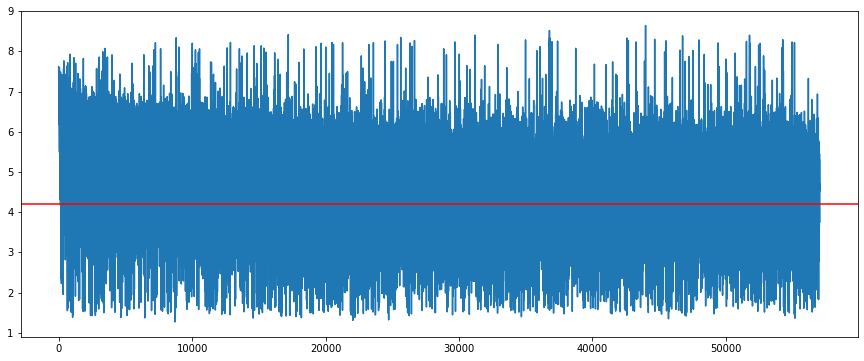

In [31]:
avg_bigram_loss=np.mean(bigram_losses)

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(losses)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')
plt.show()

# Neural Network Bigram

In [32]:
# load data
sentences,word2idx = get_sentences_with_word2idx_limit_vocab(2000)

# vocab size
V=len(word2idx)
print(V)

# START -> first word
start_idx=word2idx['START']
# END -> last word
end_idx=word2idx['END']

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

2001


In [49]:
# A matrix where
# row = last word
# col = current word
# value [rol,col] = p(current word | last word)
bigram_prob = get_bigram_prob(sentences,V, start_idx,end_idx,smoothing=1)

D=100
W1=np.random.randn(V,D)/np.sqrt(V)
W2=np.random.randn(D,V)/np.sqrt(D)

losses=[]
epoches=1
lr=1e-2

random.shuffle(sentences)
j=0
for sentence in sentences:
    # convert sentence into one-hot encoded inputs and targets
    sentence = [start_idx] + sentence + [end_idx]
    n=len( sentence)
    inputs=np.zeros((n-1,V))
    targets=np.zeros((n-1,V))

    inputs[np.arange(n-1),sentence[:n-1]] = 1
    targets[np.arange(n-1),sentence[1:]] = 1
    # get output predictions
    h=np.tanh(inputs.dot(W1))
    pred = softmax(h.dot(W2))
    # do a gradient descent step
    W2=W2-lr*h.T.dot(pred-targets)
    W1=W1-lr*inputs.T.dot((pred-targets).dot(W2.T)*(1-h**2))

    loss = -np.sum(targets*np.log(pred))/(n-1)
    losses.append(loss)
    
    if j%300==0:
        print("Epoch:",0," sentence: %s /%s"%(j,len(sentences))," loss:",loss)
    j+=1

Epoch: 0  sentence: 0 /57013  loss: 7.603481022106286
Epoch: 0  sentence: 300 /57013  loss: 5.149761907591381
Epoch: 0  sentence: 600 /57013  loss: 4.836835031544608
Epoch: 0  sentence: 900 /57013  loss: 6.3632349677070845
Epoch: 0  sentence: 1200 /57013  loss: 5.934694719419525
Epoch: 0  sentence: 1500 /57013  loss: 5.419437254504297
Epoch: 0  sentence: 1800 /57013  loss: 3.771923332532991
Epoch: 0  sentence: 2100 /57013  loss: 3.388197289806582
Epoch: 0  sentence: 2400 /57013  loss: 6.095189012941495
Epoch: 0  sentence: 2700 /57013  loss: 5.3613391412536515
Epoch: 0  sentence: 3000 /57013  loss: 1.9949026212524736
Epoch: 0  sentence: 3300 /57013  loss: 5.848074564134455
Epoch: 0  sentence: 3600 /57013  loss: 6.2316178616304825
Epoch: 0  sentence: 3900 /57013  loss: 4.850899605143172
Epoch: 0  sentence: 4200 /57013  loss: 5.987346480172419
Epoch: 0  sentence: 4500 /57013  loss: 4.815564030354999
Epoch: 0  sentence: 4800 /57013  loss: 5.034609820636105
Epoch: 0  sentence: 5100 /57013  

Epoch: 0  sentence: 42600 /57013  loss: 3.0775393118930467
Epoch: 0  sentence: 42900 /57013  loss: 4.280361574631659
Epoch: 0  sentence: 43200 /57013  loss: 3.3724750640732144
Epoch: 0  sentence: 43500 /57013  loss: 4.213754817030514
Epoch: 0  sentence: 43800 /57013  loss: 4.256166595947223
Epoch: 0  sentence: 44100 /57013  loss: 3.366374515911366
Epoch: 0  sentence: 44400 /57013  loss: 4.863368738281498
Epoch: 0  sentence: 44700 /57013  loss: 3.2012792398594887
Epoch: 0  sentence: 45000 /57013  loss: 4.601179064934699
Epoch: 0  sentence: 45300 /57013  loss: 3.642983689136923
Epoch: 0  sentence: 45600 /57013  loss: 5.305528126351122
Epoch: 0  sentence: 45900 /57013  loss: 4.032830317839806
Epoch: 0  sentence: 46200 /57013  loss: 4.208230032865405
Epoch: 0  sentence: 46500 /57013  loss: 4.107845921921425
Epoch: 0  sentence: 46800 /57013  loss: 3.4553105584889554
Epoch: 0  sentence: 47100 /57013  loss: 3.1049861458090873
Epoch: 0  sentence: 47400 /57013  loss: 3.764563612287066
Epoch: 0 

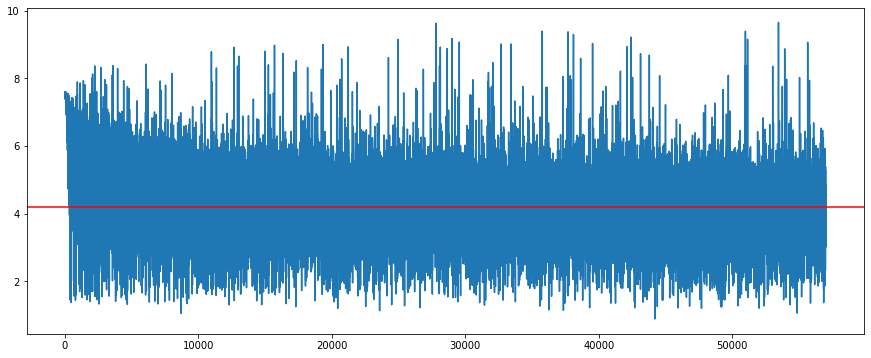

In [50]:
plt.figure(figsize=(15,6))
plt.plot(losses)
plt.axhline(y=avg_bigram_loss, color='r', linestyle='-')
plt.show()

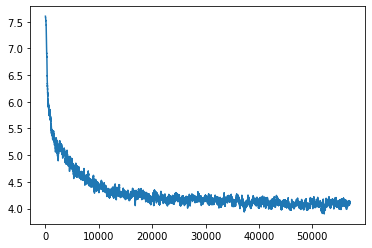

In [55]:
def smoothed_loss(x, decay=0.99):
    y = np.zeros(len(x))
    last = 0
    for t in range(len(x)):
        z = decay * last + (1 - decay) * x[t]
        y[t] = z / (1 - decay ** (t + 1))
        last = z
    return y

plt.plot(smoothed_loss(losses))
plt.show()

# Improve Efficiency

In [120]:
# load data
sentences,word2idx = get_sentences_with_word2idx_limit_vocab(2000)

# vocab size
V=len(word2idx)
print(V)

# START -> first word
start_idx=word2idx['START']
# END -> last word
end_idx=word2idx['END']

# A matrix where
# row = last word
# col = current word
# value [rol,col] = p(current word | last word)
bigram_prob = get_bigram_prob(sentences,V, start_idx,end_idx,smoothing=1)

D=100
W1=np.random.randn(V,D)/np.sqrt(V)
W2=np.random.randn(D,V)/np.sqrt(D)

losses=[]
epoches=1
lr=1e-2

START inf
END inf
man inf
paris inf
britain inf
england inf
king inf
woman inf
rome inf
london inf
queen inf
italy inf
france inf
the 69971
, 58334
. 49346
of 36412
and 28853
to 26158
a 23195
in 21337
that 10594
is 10109
was 9815
he 9548
for 9489
`` 8837
'' 8789
it 8760
with 7289
as 7253
his 6996
on 6741
be 6377
; 5566
at 5372
by 5306
i 5164
this 5145
had 5133
? 4693
not 4610
are 4394
but 4381
from 4370
or 4206
have 3942
an 3740
they 3620
which 3561
-- 3432
one 3292
you 3286
were 3284
her 3036
all 3001
she 2860
there 2728
would 2714
their 2669
we 2652
him 2619
been 2472
) 2466
has 2437
( 2435
when 2331
who 2252
will 2245
more 2215
if 2198
no 2139
out 2097
so 1985
said 1961
what 1908
up 1890
its 1858
about 1815
: 1795
into 1791
than 1790
them 1788
can 1772
only 1748
other 1702
new 1635
some 1618
could 1601
time 1598
! 1596
these 1573
two 1412
may 1402
then 1380
do 1363
first 1361
any 1344
my 1318
now 1314
such 1303
like 1292
our 1252
over 1236
me 1181
even 1170
most 1159
made 1125
also 

In [121]:

random.shuffle(sentences)
j=0
for sentence in sentences:
    # convert sentence into one-hot encoded inputs and targets
    sentence = [start_idx] + sentence + [end_idx]
    n=len( sentence)
    # first word
    inputs=sentence[:n-1]
    # 1 word after
    targets=sentence[1:]

    # get output predictions
    h=np.tanh(W1[inputs])
    pred = softmax(h.dot(W2))
    
    loss = -np.sum(np.log(pred[np.arange(n-1),targets]))/(n-1)
    losses.append(loss)
    
    # do a gradient descent step
    doutput=pred
    doutput[np.arange(n-1),targets] -=1
    W2=W2-lr*h.T.dot(doutput)
    
    d_h=doutput.dot(W2.T)*(1-h**2)
    
    for i,w in enumerate(inputs):
        W1[w]-=lr*d_h[i]
        
    
    
    if j%300==0:
        print("Epoch:",0," sentence: %s /%s"%(j,len(sentences))," loss:",loss)
    j+=1

Epoch: 0  sentence: 0 /57013  loss: 7.603955335703646
Epoch: 0  sentence: 300 /57013  loss: 5.585708094791866
Epoch: 0  sentence: 600 /57013  loss: 3.3748602678685415
Epoch: 0  sentence: 900 /57013  loss: 5.803808480963506
Epoch: 0  sentence: 1200 /57013  loss: 5.697648634989796
Epoch: 0  sentence: 1500 /57013  loss: 4.608732838818665
Epoch: 0  sentence: 1800 /57013  loss: 4.939602334457746
Epoch: 0  sentence: 2100 /57013  loss: 4.543987720131132
Epoch: 0  sentence: 2400 /57013  loss: 4.891477601591525
Epoch: 0  sentence: 2700 /57013  loss: 5.583439886704416
Epoch: 0  sentence: 3000 /57013  loss: 5.952122952064092
Epoch: 0  sentence: 3300 /57013  loss: 5.516085363281462
Epoch: 0  sentence: 3600 /57013  loss: 5.258029691716872
Epoch: 0  sentence: 3900 /57013  loss: 5.441122021724389
Epoch: 0  sentence: 4200 /57013  loss: 5.5686811920613986
Epoch: 0  sentence: 4500 /57013  loss: 5.124979315133123
Epoch: 0  sentence: 4800 /57013  loss: 6.093111240846404
Epoch: 0  sentence: 5100 /57013  lo

Epoch: 0  sentence: 42600 /57013  loss: 3.846913193769663
Epoch: 0  sentence: 42900 /57013  loss: 3.5885596968456146
Epoch: 0  sentence: 43200 /57013  loss: 4.384974165014053
Epoch: 0  sentence: 43500 /57013  loss: 3.2046513643636696
Epoch: 0  sentence: 43800 /57013  loss: 4.334533337605782
Epoch: 0  sentence: 44100 /57013  loss: 4.168644515358706
Epoch: 0  sentence: 44400 /57013  loss: 3.712233602209761
Epoch: 0  sentence: 44700 /57013  loss: 4.050439127684602
Epoch: 0  sentence: 45000 /57013  loss: 2.950941414993096
Epoch: 0  sentence: 45300 /57013  loss: 4.966926594954296
Epoch: 0  sentence: 45600 /57013  loss: 4.510101948091563
Epoch: 0  sentence: 45900 /57013  loss: 3.37480348501532
Epoch: 0  sentence: 46200 /57013  loss: 3.5242356776791617
Epoch: 0  sentence: 46500 /57013  loss: 3.5818625028278763
Epoch: 0  sentence: 46800 /57013  loss: 3.1020881942311034
Epoch: 0  sentence: 47100 /57013  loss: 4.493006799938949
Epoch: 0  sentence: 47400 /57013  loss: 4.3719819835000715
Epoch: 0 

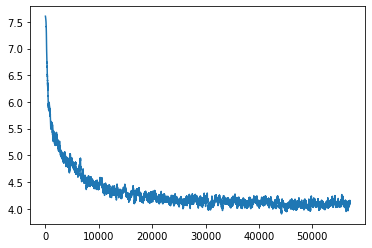

In [122]:
plt.plot(smoothed_loss(losses))
plt.show()